In [1]:
# note: you may need to install lightgbm manually if you run into issues with pip
# see https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html

!pip install mljar-supervised statsmodels pandas scikit-learn ipywidgets md2pdf --quiet
!pip install scikit-learn==1.2.2 --quiet # needed to avoid warnings until mljar-supervised is updated for scikit-learn 1.3.0+

# alternatively, you may try installing via conda/mamba:

# !conda install mljar-supervised statsmodels pandas scikit-learn --quiet
# or
# !mamba install mljar-supervised statsmodels pandas scikit-learn --quiet

In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay
from supervised.automl import AutoML
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', 'The figure layout has changed to tight')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# adapted from https://github.com/davedgd/python-class-examples/blob/main/TitanicSurvival_DescriptiveLogisticML.ipynb 

TitanicSurvival = sm.datasets.get_rdataset('TitanicSurvival', 'carData', cache = True).data

Train, Test = train_test_split(TitanicSurvival, 
                               stratify = TitanicSurvival.survived,
                               test_size = 0.20, 
                               random_state = 345)

np.random.seed(345) # to create reproducible results

maj_class = np.where(Train.survived == 'no')[0]
min_class = np.where(Train.survived == 'yes')[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

X_train = TrainDS.drop(columns = 'survived')
y_train = TrainDS.survived.replace(['no', 'yes'], [0, 1])
X_test = Test.drop(columns = 'survived')
y_test = Test.survived.replace(['no', 'yes'], [0, 1])

In [4]:
# note: see results in file browser
automl = AutoML(mode = 'Explain')
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.693147 trained in 0.2 seconds
2_DecisionTree logloss 0.485189 trained in 3.04 seconds
3_Linear logloss 0.456719 trained in 2.53 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.445369 trained in 2.4 seconds
5_Default_NeuralNetwork logloss 0.427873 trained in 2.45 seconds
6_Default_RandomForest logloss 0.426804 trained in 3.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.420932 trained in 0.78 seconds
AutoML fit time: 18.29 seconds
AutoML best model: Ensemble


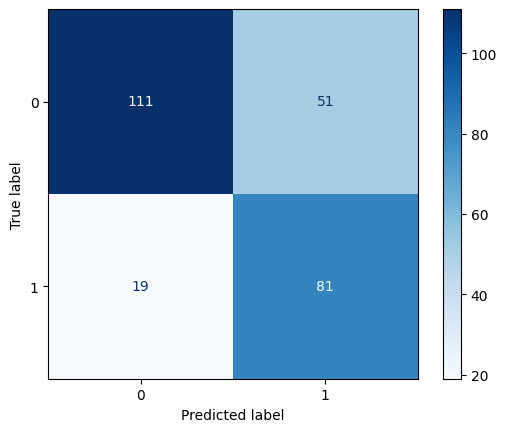

In [5]:
ConfusionMatrixDisplay.from_predictions(y_true = y_test, 
                                        y_pred = predictions, 
                                        cmap = plt.cm.Blues)

In [6]:
balanced_accuracy_score(y_test, predictions).round(3)

0.748

In [7]:
# markdown to pdf report conversion (optional)
# note: you may need to refresh the file browser to see the output

result_folder = 'AutoML_1'

if 'google.colab' in str(get_ipython()):
    from md2pdf.core import md2pdf
    
    css = '''
    @media print{
      img {
        width: 100%;
        height: 100%;
      }
    
      body {
        font-size: 80%;
      }
    }
    '''
    
    with open("md2pdf.css", 'w') as f:
        f.write(css)
    
    md2pdf(pdf_file_path = './' + result_folder + '_Results.pdf',
           md_content = None,
           md_file_path = './' + result_folder + '/README.md',
           css_file_path = './md2pdf.css',
           base_url = './' + result_folder)